In [4]:
from util.parse_worker import parse_worker
import matplotlib.pyplot as plt
import matplotlib

font = {
    "family": "Times New Roman",
    'size': 18
}

matplotlib.rc('font', **font)

df, stat = parse_worker()
df

,id,job_name,worker_name,replica_type,host_ip,gmt_created,gmt_pod_running,gmt_pod_finished,RES,duration,num_gpus
0,28613,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-master-0,master,8bd29cd3a6c570901c5ce23aa0a5557266068fc370e1e4...,0.032639,NaN,0.034028,"{'cpu': '96', 'memory': '1600Gi', 'nvidia.com/...",0.001389,8.0
1,28614,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-0,worker,46547b40034dea27dff7a94dee665d3804b7869286d00d...,0.032639,NaN,0.034028,"{'cpu': '96', 'memory': '1600Gi', 'nvidia.com/...",0.001389,8.0
2,28615,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-1,worker,47b54b963095fc8211922de281e8a1306783c9809d8ca6...,0.032639,NaN,0.034028,"{'cpu': '96', 'memory': '1600Gi', 'nvidia.com/...",0.001389,8.0
3,28616,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-2,worker,7acd990b9db2ffb8b982727c3463746e7c25e0f215c28f...,0.032639,NaN,0.034028,"{'cpu': '96', 'memory': '1600Gi', 'nvidia.com/...",0.001389,8.0
4,28617,dlcar6cqs8mecvlz,dlcar6cqs8mecvlz-worker-3,worker,2d1f3f74639b00279140135610e4d4cce920754951735f...,0.032639,NaN,0.034028,"{'cpu': '96', 'memory': '1600Gi', 'nvidia.com/...",0.001389,8.0
...,...,...,...,...,...,...,...,...,...,...,...
23737,52350,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-0,worker,dff008ec40ff0277063879a26fe20839dea357546f8431...,15.952083,2023/7/30 22:53,16.813889,"{'cpu': '48', 'memory': '1600Gi', 'nvidia.com/...",0.861806,8.0
23738,52351,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-1,worker,931e2b5303ad17ad1632a92d75d503163d05102bcd2837...,15.952083,2023/7/30 22:53,16.813889,"{'cpu': '48', 'memory': '1600Gi', 'nvidia.com/...",0.861806,8.0
23739,52352,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-2,worker,93de899743acb06a5fc647679f38ca308b4c37fd290322...,15.952083,2023/7/30 22:53,16.813889,"{'cpu': '48', 'memory': '1600Gi', 'nvidia.com/...",0.861806,8.0
23740,52353,dlc1g3ccn8neahh9,dlc1g3ccn8neahh9-worker-3,worker,0bcb143b0d5ecfc59ff7d91e6d254d65ed066352b5317e...,15.952083,2023/7/30 22:53,16.813889,"{'cpu': '48', 'memory': '1600Gi', 'nvidia.com/...",0.861806,8.0


In [5]:
stat

[(28, 'MissingTime'),
 (946, 'InvalidDuration'),
 (2917, 'InvalidIP'),
 (5, 'MissingRes'),
 (19846, 'Valid')]

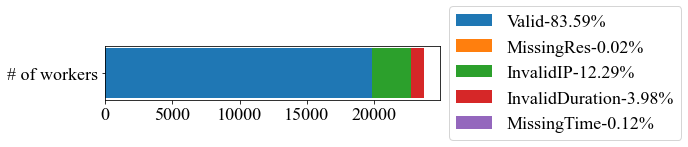

In [6]:
fig, ax = plt.subplots(figsize=(6, 1))
num_total = sum([v for v, _ in stat])
accumulate = 0
for num, reason in stat[::-1]:
    b = ax.barh([0], num, left=accumulate, label=f"{reason}-{num/num_total*100:.2f}%")
    accumulate += num
    
ax.set_yticks([0], labels=["# of workers"])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))